<a href="https://colab.research.google.com/github/electropavuk/crypto_trader/blob/master/ipynb/MAcrossover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# !pip install python-dotenv python-binance 

In [14]:
import os
import datetime
import random

from dotenv import load_dotenv
from binance import Client
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

np.set_printoptions(edgeitems=10, linewidth=200)
pd.options.mode.chained_assignment = None 

google_drive_dir = '/content/drive/MyDrive/Colab Notebooks/crypto_trader/'
load_dotenv(google_drive_dir + '.env')

api_key = os.getenv('READONLY_API_KEY')
secret_key = os.getenv('READONLY_SECRET_KEY')

client = Client(api_key, secret_key)

In [15]:
def get_history(symbol, interval, period):
    base, quote = 'BTC', 'USDT'
    klines = client.get_historical_klines(symbol=symbol, interval=interval, start_str= period + ' ago UTC')
    labels = ['Open time', 'Open', 'High', 'Low', 'Close', 
    		  base + ' volume', 'Close time', quote + ' volume', 'Number of trades',
    		  f'{base} buy volume', f'{quote} sell volume', 'Ignore']
    df = pd.DataFrame(data=klines, columns=labels, dtype=float)
    return df


history = get_history(symbol='BTCUSDT', interval='1h', period='500 days')

In [16]:
def prepare_data(df, MAs=(7, 25)):
    df = df[['Close']]

    for avg in MAs:
        df[f'{avg} MA'] = df['Close'].rolling(avg).mean()
        df[f'{avg} EMA'] = df['Close'].ewm(span=avg).mean()
    
    df = df.dropna()
    
    return df, None


In [17]:
def act(aslow, afast, bslow, bfast):
    # yesterday slow / fast, today slow / fast
    if afast < aslow and bfast > bslow:
        return 'buy'
    elif afast > aslow and bfast < bslow:
        return 'sell'
    else:
        return 'wait'

def simulate(data, n, money=1000, slow=7, fast=25, name='MA'):
    slow = f'{slow} {name}'
    fast = f'{fast} {name}'

    trades = []
    init_money = balance = money
    quantity = 0

    for t in range(-n, 0):
        aslow, afast = data[slow].iloc[t - 1], data[fast].iloc[t - 1]
        bslow, bfast = data[slow].iloc[t], data[fast].iloc[t]
        price = data['Close'].iloc[t]

        action = act(aslow, afast, bslow, bfast)
        if action == 'buy' and balance > 0:
            buy_price = price
            quantity = balance / price
            balance = 0
            trades.append(('buy', t, price, quantity))
        elif action == 'sell' and quantity > 0:
            trades.append(('sell', t, price, quantity))
            balance = quantity * price
            quantity = 0
    
    if quantity > 0:
        balance += quantity * buy_price
        trades.pop()
    
    profit = (balance - init_money) / init_money
    return trades, profit

In [18]:
def best_parameters(profits):
    return max(profits)

def search_parameters():
    pairs = [(i, j) for i in range(4, 35, 3) for j in range(2, i, 2)]

    profits = []
    for slow, fast in pairs:
        data, price = prepare_data(history, (slow, fast))
        assert n < len(data)
        trades, profit = simulate(data, money=money, n=n, slow=slow, fast=fast, name='MA')
        # print('slow = {:<5}, fast = {:<5} : profit = {:.1f} %'.format(slow, fast, profit * 100))
        profits.append((profit, (slow, fast)))

    profit, (slow, fast) = best_parameters(profits)
    print('slow = {:<5}, fast = {:<5} : profit = {:.1f} %'.format(slow, fast, profit * 100))
    return slow, fast

slow = 16   , fast = 12    : profit = 95.6 %


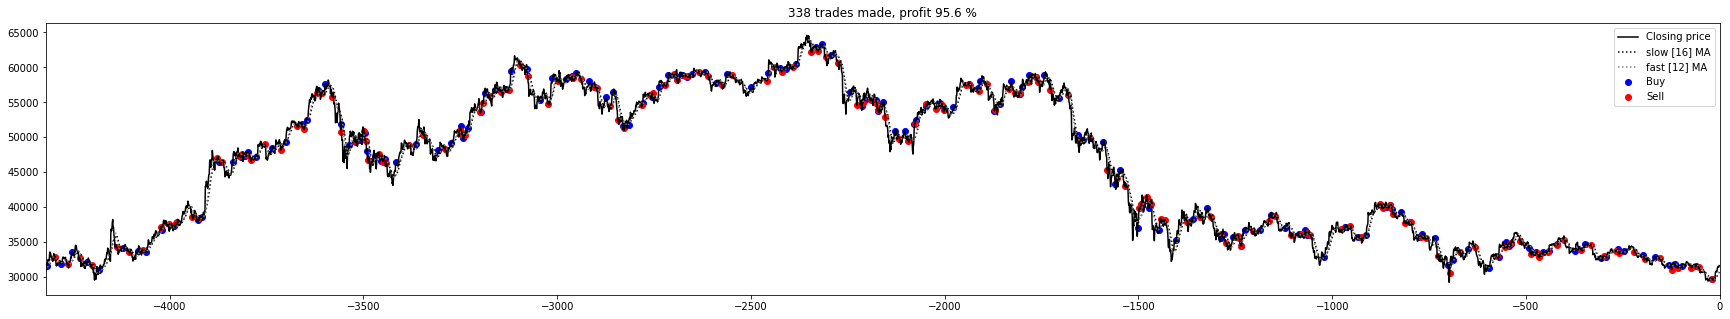

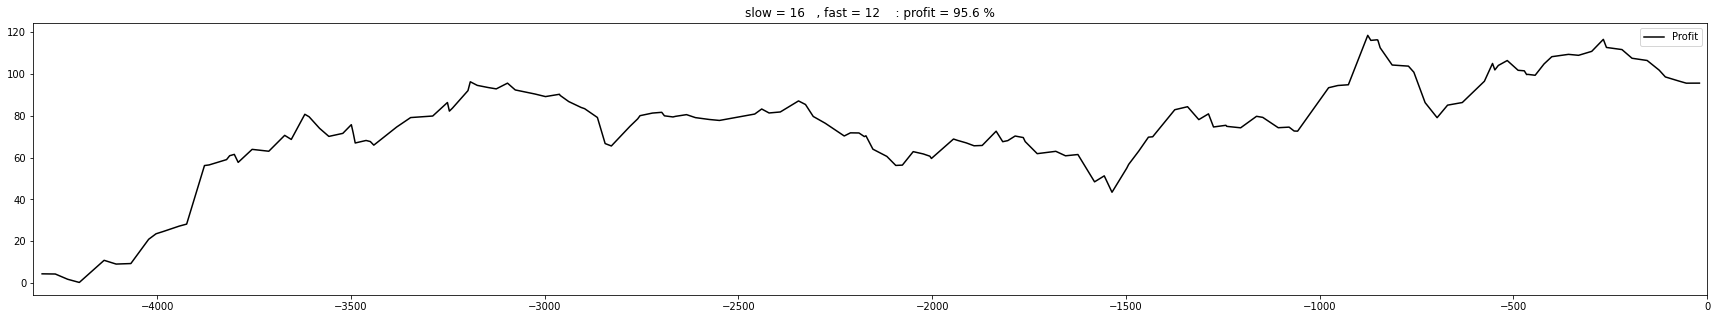

In [19]:
n = 24 * 180
money = 100

slow, fast = search_parameters()
data, price = prepare_data(history, (slow, fast))

trades, profit = simulate(data, n, slow=slow, fast=fast)

xsell, ysell, xbuy, ybuy = [], [], [], []
for action, t, price, quantity in trades:
    if action == 'buy':
        xbuy.append(t)
        ybuy.append(price)
    if action == 'sell':
        xsell.append(t)
        ysell.append(price)


plt.figure(figsize = (30, 5))
plt.title('{} trades made, profit {:.1f} %'.format(len(trades), profit * 100))
plt.xlim((-n, 0))
plt.plot(range(-n, 0), data['Close'].iloc[-n:], label='Closing price', c='black')
plt.plot(range(-n, 0), data[f'{slow} MA'].iloc[-n:], label=f'slow [{slow}] MA', c='black', linestyle=':')
plt.plot(range(-n, 0), data[f'{fast} MA'].iloc[-n:], label=f'fast [{fast}] MA', c='grey', linestyle=':')
plt.scatter(xbuy, ybuy, label='Buy', c='blue')
plt.scatter(xsell, ysell, label='Sell', c='red')
plt.legend()

xprofit, yprofit = [], []
balance = init_money = money
for action, t, price, quantity in trades:
    if action == 'buy':
        buy_price = price
    elif action == 'sell':
        sell_price = price
        balance *= (sell_price / buy_price)
        xprofit.append(t)
        yprofit.append(100 * (balance - init_money) / init_money)



plt.figure(figsize = (30, 5))
plt.title('slow = {:<5}, fast = {:<5} : profit = {:.1f} %'.format(slow, fast, profit * 100))
plt.xlim((-n, 0))
plt.plot(xprofit, yprofit, label='Profit', c='black')
plt.legend()
